# Notebook to compare results to gPhoton
Setup your source parameter and setting in the cell below.

In [1]:
region_name = "ALL_10-800_LOOSE" 
outdir = "./resources/gPhoton_out/"
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+"_cat.fits"

srcs_ids = [4993 ,13580 ,14504 ,30475 ,50388 ,52994 ,79477 ,120265 ,138783 ,139480 ,162697 ,204419 ,221349 ,228958 ,236839 ,253214 ,253670
            ,256433 ,261213 ,331466 ,340464 ,381336 ,390864 ,489430 ,498065 ,525310 ,532554 ,533185 ,540235 ,583838 ,639720 ,645215 ,645730
            ,659787 ,666224 ,673175 ,680119 ,691408 ,714140 ,764827 ,1037284 ,1069077 ,1070938 ,1805505 ,1839206 ,2527679 ,3074917 ,] 
#srcs_ids = [4993]

In [2]:
%matplotlib widget
import ipywidgets as widgets
import gPhoton
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.table import Table, join, vstack, MaskedColumn
from astropy import units as uu
import os
from vasca.utils import mag2flux, flux2mag, tgalex_to_astrotime
import vasca.visualization as vvis
from vasca.region import Region
from vasca.resource_manager import ResourceManager
import warnings
warnings.filterwarnings('ignore')

rg = Region()
rg.load_from_fits(region_fname)

#Subselect sources based on choice
if len(srcs_ids)>0:
    rg.tt_sources.add_index("rg_src_id")
    idx_srcs = rg.tt_sources.loc_indices["rg_src_id", srcs_ids]
    tt_srcs = Table(rg.tt_sources[idx_srcs])
else:
    tt_srcs = rg.tt_sources


#display(tt_srcs)

### Do aperture photometry for each visit with gPhoton

Nr of points all/matched: 3712 / 1891


time_gp,time_bin_size_gp,flux_gp,flux_err_gp,ul_gp,sel_gp,obs_filter_gp,obs_filter_id,flags,s2n,rg_src_id,rtime,time_src,time_bin_size_src,flux_src,flux_err_src,ul_src,sel_src,obs_filter_src,pull
d,s,1e-06 Jy,1e-06 Jy,1e-06 Jy,,,,,,,,d,s,1e-06 Jy,1e-06 Jy,1e-06 Jy,,,1e-06 Jy
float64,float32,float32,float32,float32,bool,bytes8,int32,int64,float32,int64,float64,float64,float32,float32,float32,float32,bool,bytes8,float32
54003.40316545139,1699.0,128.22168,3.164159,-1.0,False,FUV,2,40,42.329865,4993,54003.4,54003.403148148,1696.0,148.24286,4.800507,-1.0,True,FUV,-4.1706386
54319.91050341435,425.0,141.25937,6.791858,-1.0,False,FUV,2,40,22.292236,4993,54319.91,54319.91050347215,425.0,127.882996,3.2203603,-1.0,True,FUV,4.1536884
54317.29756359954,1039.0,57.31497,2.845131,-1.0,False,FUV,2,40,22.4274,30475,54317.3,54317.29756365762,1039.0,100.54693,5.7001624,-1.0,True,FUV,-7.584338
54319.83470480324,1691.0,64.190575,2.875808,-1.0,False,FUV,2,105,24.34117,30475,54319.83,54319.83151186335,1139.25,101.60306,2.5695488,-1.0,True,FUV,-14.559942
53749.339797395834,1541.0,146.70445,3.4697814,-1.0,False,FUV,2,65,43.085407,50388,53749.34,53749.33976851873,1536.0,241.72145,4.323928,-1.0,True,FUV,-21.974695
53749.81987262731,1662.0,129.14708,3.1440353,-1.0,False,FUV,2,8,42.159176,50388,53749.82,53749.819872684704,1662.0,191.00182,4.913412,-1.0,True,FUV,-12.588958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54371.324334432866,1245.0,219.17728,4.7044325,-1.0,False,FUV,2,32,47.306282,680119,54371.32,54371.3243174194,1242.05,236.08145,3.798506,-1.0,True,FUV,-4.450217


time_gp,time_bin_size_gp,flux_gp,flux_err_gp,ul_gp,sel_gp,obs_filter_gp,obs_filter_id,flags,s2n,rg_src_id,rtime,time_src,time_bin_size_src,flux_src,flux_err_src,ul_src,sel_src,obs_filter_src
d,s,1e-06 Jy,1e-06 Jy,1e-06 Jy,,,,,,,,d,s,1e-06 Jy,1e-06 Jy,1e-06 Jy,,
float64,float32,float32,float32,float32,bool,bytes8,int32,int64,float32,int64,float64,float64,float32,float32,float32,float32,bool,bytes8
52882.65150457176,1674.0,136.79631,2.0042207,-1.0,False,NUV,1,32,68.44618,4993,52882.65,52882.651504629706,1674.0,138.2633,2.018633,-1.0,True,NUV
52888.26343744213,930.0,136.8559,2.7028084,-1.0,False,NUV,1,32,52.20979,4993,52888.26,52888.26342592613,928.0,136.56549,2.8844364,-1.0,True,NUV
52895.1794328125,382.0,138.40518,4.3184843,-1.0,False,NUV,1,32,32.650913,4993,52895.18,52895.179415798644,379.05,138.74472,4.3294063,-1.0,True,NUV
52895.25034716435,796.0,137.46028,2.9306936,-1.0,False,NUV,1,32,47.586052,4993,52895.25,52895.25034722238,796.0,138.77133,3.0022376,-1.0,True,NUV
52895.32104739583,1173.0,134.72293,2.388478,-1.0,False,NUV,1,32,57.992535,4993,52895.32,52895.32100144703,1165.05,135.8088,2.5126293,-1.0,True,NUV
52895.66221637731,929.0,140.62672,2.750026,-1.0,False,NUV,1,32,51.528828,4993,52895.66,52895.662164930196,920.1,141.68544,2.7586784,-1.0,True,NUV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55492.44405086806,694.0,123.28868,3.4083111,-1.0,False,NUV,1,32,36.65956,3074917,55492.44,--,--,--,--,--,--,0.0


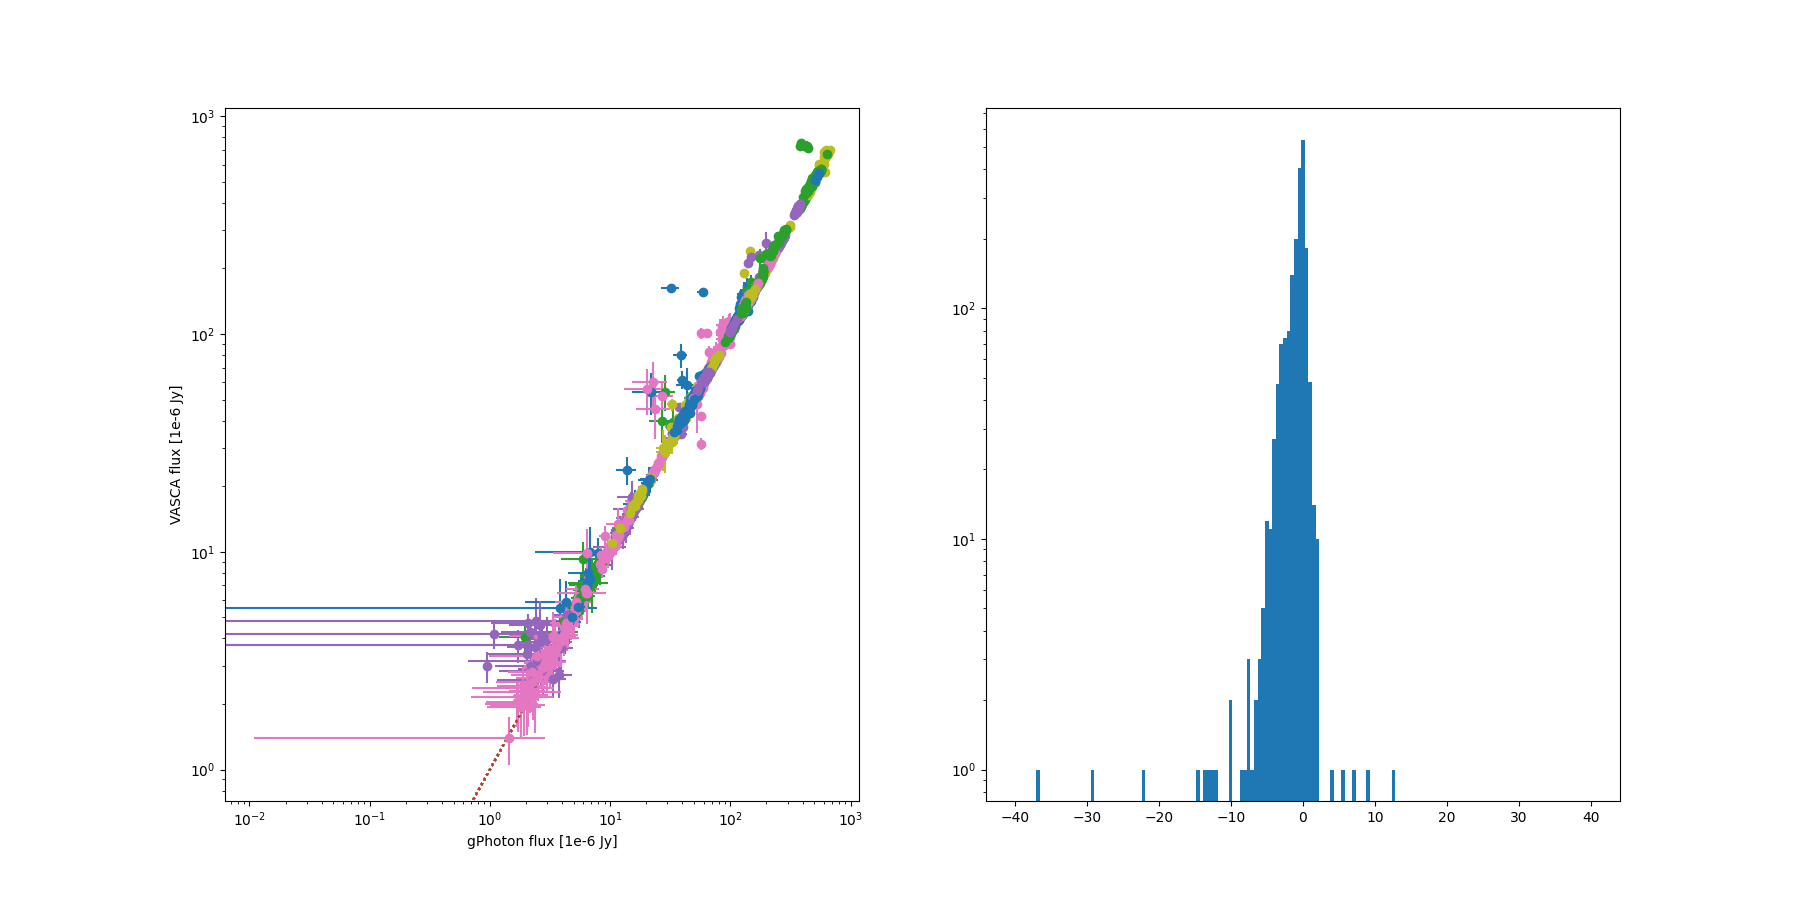

In [3]:
fig, axs = plt.subplots(1,2,figsize=(18, 9), squeeze=True, num="gPhotFlux", clear=True) 
axs = axs.flatten()
ll_lc = []
for rg_src_id in srcs_ids:

    #Get source
    tc_src = rg.get_src_from_id(rg_src_id, load_from_file = True, add_sed=False,add_gphoton=True, add_spectrum=False)
    tt_gp_lc = tc_src.tt_gphoton_lc
    tt_gp_lc["rg_src_id"] = rg_src_id
    tt_gp_lc["rtime"]=np.round(tt_gp_lc["time"],2)
    tt_src_lc = tc_src.tt_source_lc
    tt_src_lc["rtime"]=np.round(tt_src_lc["time"],2)
    tt_lc = join(tt_gp_lc,tt_src_lc,keys=['obs_filter_id',"rtime"],join_type='outer',table_names=["gp","src"])
    tt_lc["time_gp"] = MaskedColumn(tt_lc["time_gp"])
    tt_lc["time_src"]= MaskedColumn(tt_lc["time_src"])
    #display(tt_lc)
    sel_both = ~tt_lc["time_gp"].mask*~tt_lc["time_src"].mask
    tt_lc_both = tt_lc[sel_both]
    #sel_gp = tt_lc_both["sel_gp"]#*tt_lc_both["s2n"]>3

    ll_lc.append(tt_lc)
    #display(tt_lc[sel_both])
    
    #axs[0].plot(,"o")
    axs[0].errorbar(tt_lc_both["flux_gp"],tt_lc_both["flux_src"], xerr=tt_lc_both["flux_err_gp"], yerr=tt_lc_both["flux_err_src"],linestyle="none",marker="o")
    axs[0].set_xlabel("gPhoton flux [1e-6 Jy]")
    axs[0].set_ylabel("VASCA flux [1e-6 Jy]")
    axs[0].set_xscale("log")
    axs[0].set_yscale("log")
    axs[0].plot(range(600),range(600),":")
tt_lc = vstack(ll_lc)
sel_both = (~tt_lc["time_gp"].mask*~tt_lc["time_src"].mask)#*tt_lc["sel_gp"]
tt_lc_both = tt_lc[sel_both]
tt_lc_both["pull"] = (tt_lc_both["flux_gp"]-tt_lc_both["flux_src"])/tt_lc_both["flux_err_src"]
axs[1].hist(tt_lc_both["pull"],bins=np.linspace(-40,40,160))
axs[1].set_yscale("log")
print("Nr of points all/matched:",len(tt_lc),"/",len(tt_lc_both))
display(tt_lc_both[np.abs(tt_lc_both["pull"])>4])
display(tt_lc)


In [4]:
# Calculate apperture flux correctin from http://www.galex.caltech.edu/researcher/techdoc-ch5.html
f1 = mag2flux(19)
f2 = mag2flux(19-0.12)
mag = flux2mag(f2)
print(f1,f2,f2/f1, mag)


91.20108393559062 1e-06 Jy 101.8591388054115 1e-06 Jy 1.1168632477805633 18.88 mag(AB)
